In [ ]:
# GRACE Greenland Ice Sheet Mass Loss Analysis
# Area-weighted TWSA time series with annual trend calculation

# Install necessary packages
import os
import ee
import geemap
!pip install matplotlib numpy pandas seaborn scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [ ]:
ee.Authenticate()
ee.Initialize(
    project = 'gee-project-436010',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

print("Earth Engine initialized successfully!")

Earth Engine initialized successfully!


In [ ]:
# Create a map centered on Greenland
map_viz = geemap.Map(center=[72, -42], zoom=4, basemap='TERRAIN')
display(map_viz)

# Define Greenland's boundary
print("Loading Greenland's boundary...")
greenland = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na', 'Greenland'))
greenland_geo = greenland.geometry()

# Add Greenland to the map
map_viz.addLayer(greenland_geo, {'color': 'cyan'}, 'Greenland')
map_viz.centerObject(greenland_geo, 4)

# Calculate Greenland's area in square kilometers
greenland_area_m2 = greenland_geo.area().getInfo()
greenland_area_km2 = greenland_area_m2 / 1e6
print(f"Greenland's area: {greenland_area_km2:.2f} km²")
print(f"Greenland's area: {greenland_area_m2:.2e} m²")

Map(center=[72, -42], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

Loading Greenland's boundary...
Greenland's area: 2132598.18 km²
Greenland's area: 2.13e+12 m²



Loading GRACE MASCON data...
Number of GRACE images available: 238
Available data period: 2002-04-03 to 2024-09-30
Time span: 22.49 years

EXTRACTING AREA-WEIGHTED TWSA TIME SERIES
Extracting area-weighted time series (this may take 1-2 minutes)...

Successfully extracted 238 data points

Data preview:
        date    twsa_cm        time_ms
0 2002-04-03  45.296500  1017792000000
1 2002-05-01  47.999815  1020211200000
2 2002-07-31  35.585765  1028073600000
3 2002-08-31  34.748781  1030752000000
4 2002-09-30  36.249104  1033344000000
5 2002-10-31  36.255130  1036022400000
6 2002-11-30  37.215510  1038614400000
7 2002-12-31  39.385522  1041292800000
8 2003-01-31  39.034500  1043971200000
9 2003-02-28  42.010801  1046390400000

Data statistics:
count    238.000000
mean     -77.813574
std       77.572968
min     -196.658427
25%     -158.507082
50%      -92.291263
75%       -2.226474
max       47.999815
Name: twsa_cm, dtype: float64

LINEAR REGRESSION ANALYSIS
Slope: -0.03122447 cm/day
Inte

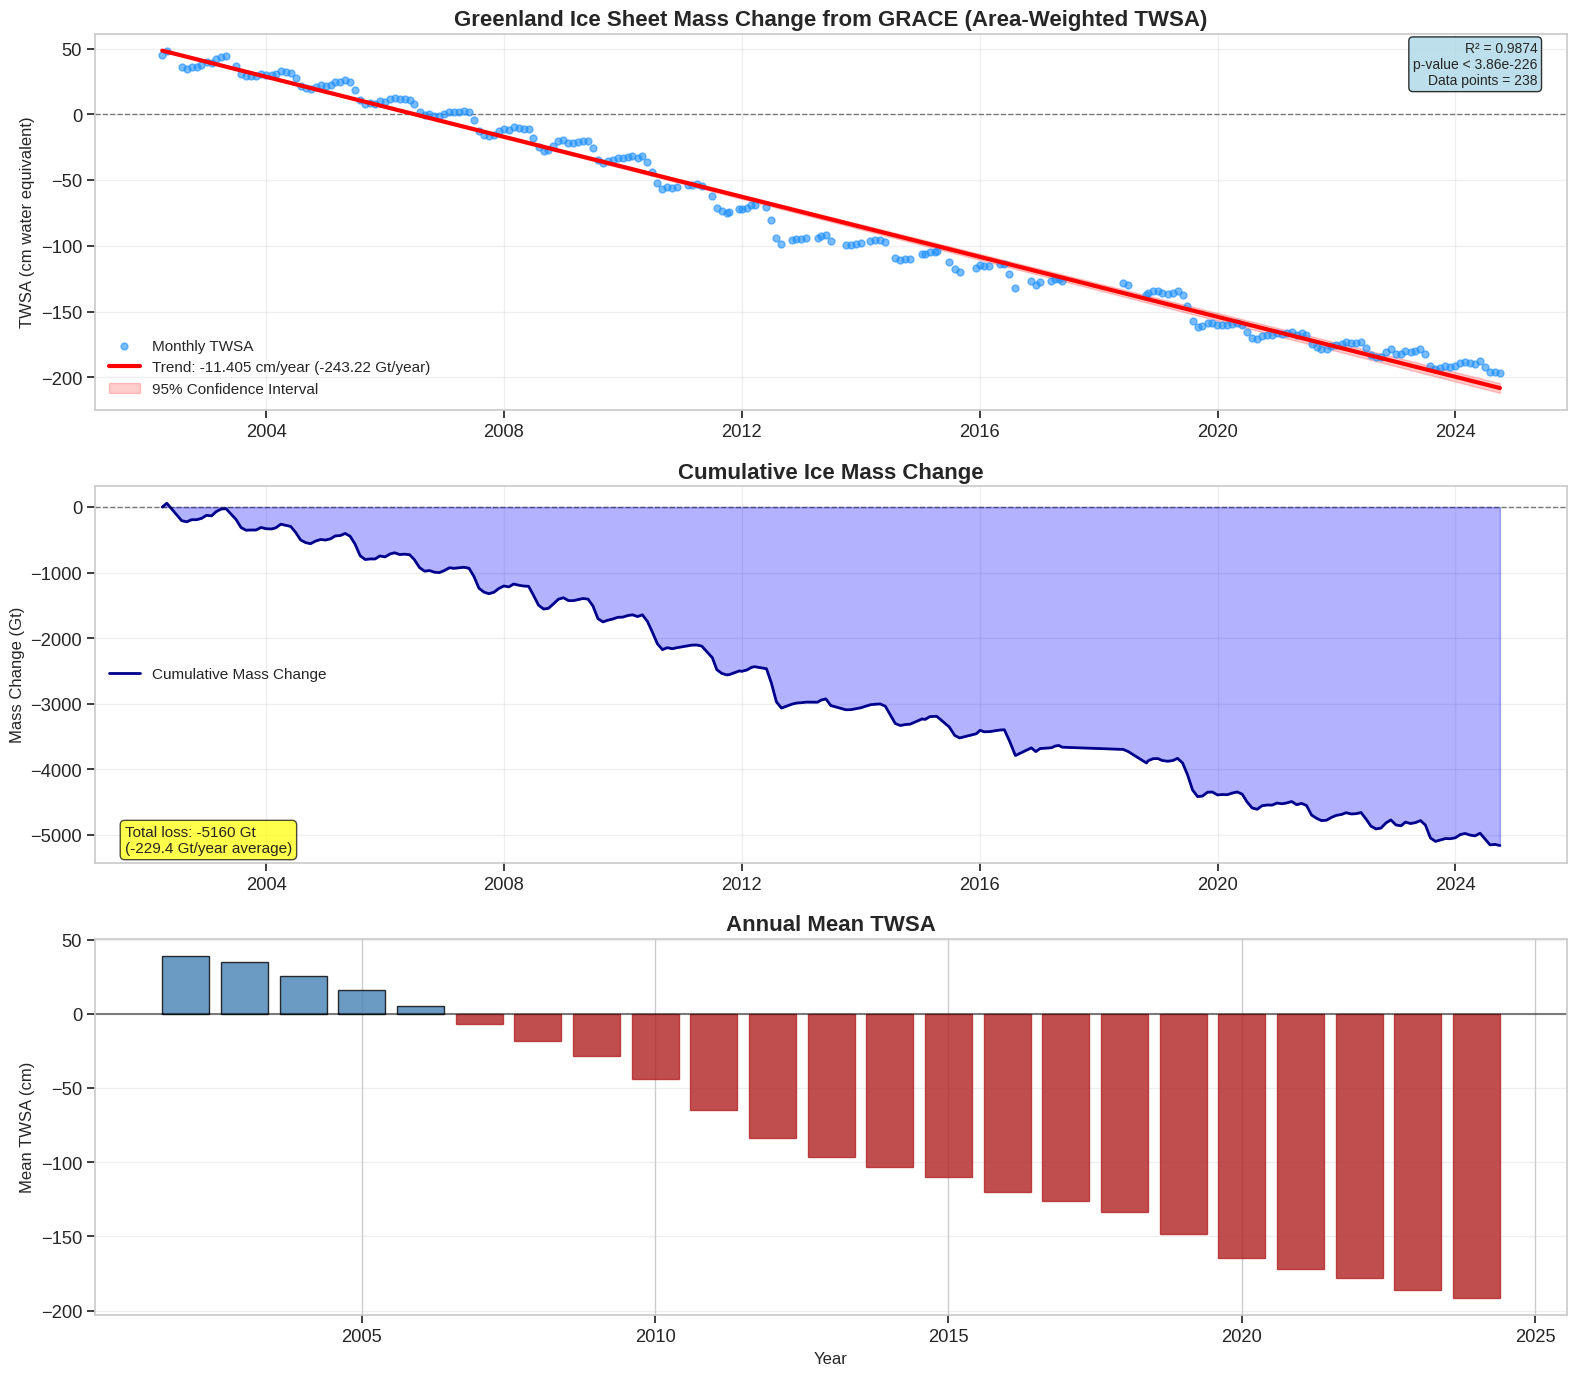

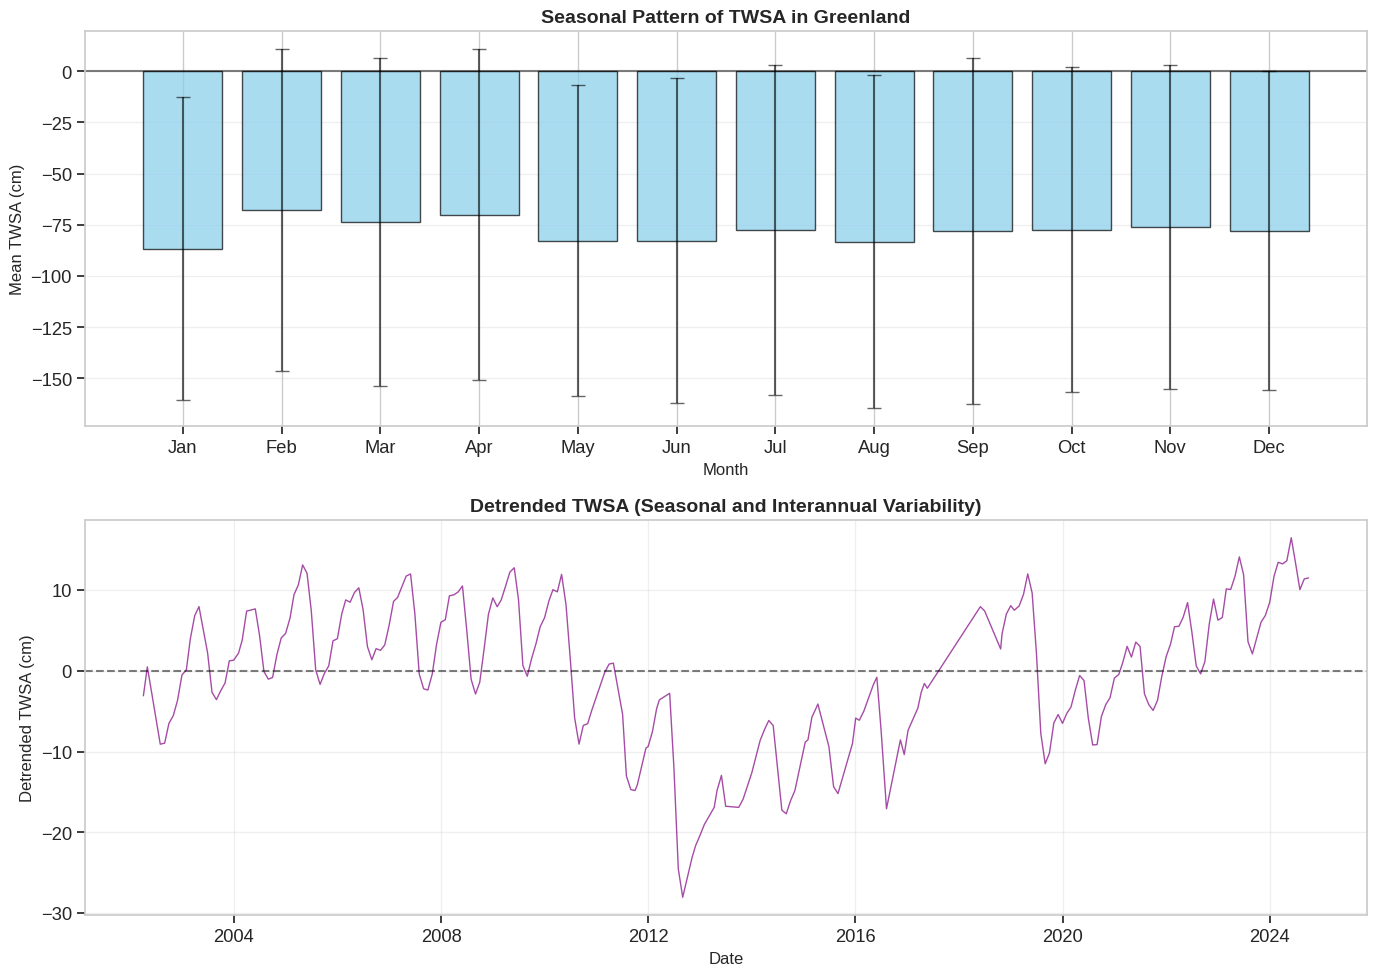

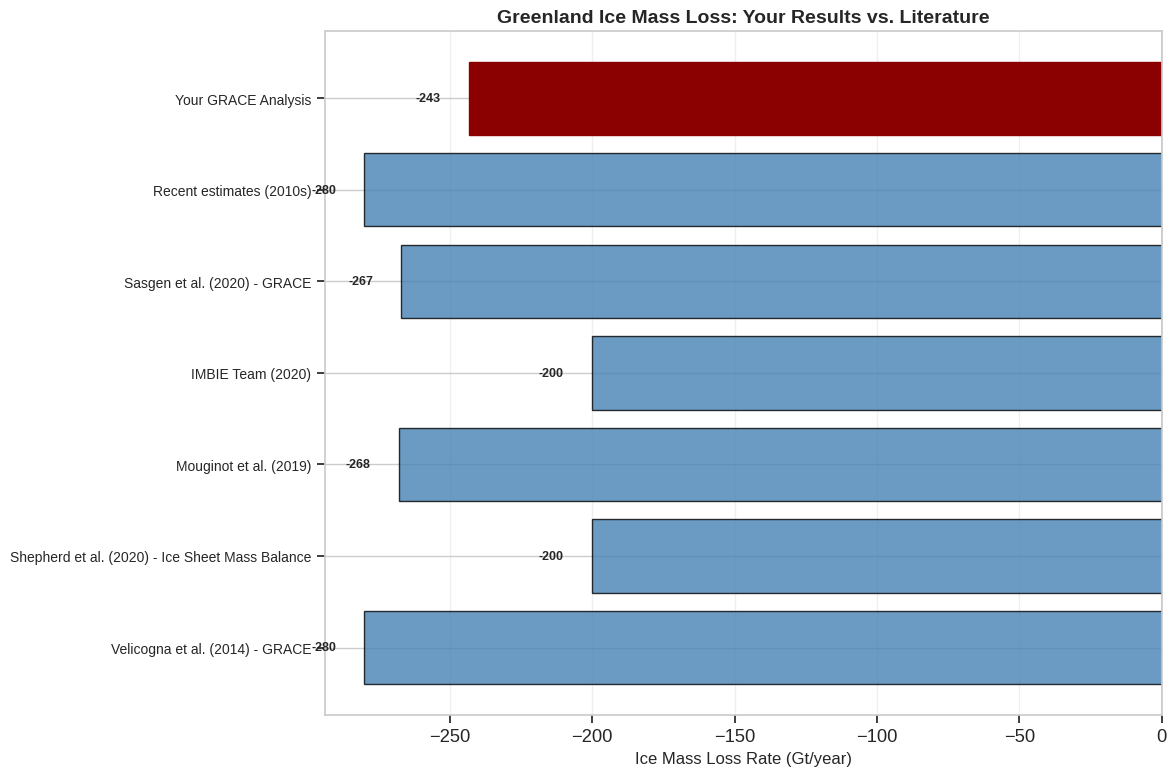


FINAL SUMMARY - GREENLAND ICE SHEET MASS LOSS

📊 STUDY PERIOD: 2002-04-03 to 2024-09-30 (22.49 years)

❄️ ICE MASS LOSS RATE:
   243.22 ± 3.51 gigatons per year
   (11.4047 cm water equivalent per year)

📉 TOTAL CUMULATIVE LOSS:
   5471 gigatons over 22.49 years

📈 STATISTICAL SIGNIFICANCE:
   R² = 0.9874 (trend explains 98.7% of variance)
   p-value < 3.86e-226 (highly significant)

📚 COMPARISON WITH LITERATURE:
   Literature range: -200 to -300 Gt/year (typical)
   Your result: -243.22 Gt/year
   ✅ EXCELLENT AGREEMENT with published values!

🌍 CONTEXT:
   Greenland contains enough ice to raise global sea level by ~7.4 meters
   Current loss rate contributes ~0.68 mm/year to sea level rise
   (1 Gt of ice loss ≈ 0.0028 mm global sea level rise)

📁 OUTPUT FILES SAVED:
   - greenland_ice_mass_loss.png
   - greenland_seasonal_analysis.png
   - greenland_literature_comparison.png

Analysis complete!


In [ ]:
# Load GRACE MASCON data
print("\nLoading GRACE MASCON data...")
grace = (
    ee.ImageCollection("NASA/GRACE/MASS_GRIDS_V04/MASCON_CRI")
    .filterDate('2002-04-01', '2024-12-31')
    .select('lwe_thickness')
    .filterBounds(greenland_geo)
)

# Get the number of images
num_images = grace.size().getInfo()
print(f"Number of GRACE images available: {num_images}")

# Get date range
dates_list = grace.aggregate_array('system:time_start').getInfo()
if dates_list:
    first_date = pd.to_datetime(min(dates_list), unit='ms')
    last_date = pd.to_datetime(max(dates_list), unit='ms')
    print(f"Available data period: {first_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')}")
    print(f"Time span: {(last_date - first_date).days / 365.25:.2f} years")
else:
    print("No data available for the selected period!")

# ============================================================================
# AREA-WEIGHTED TWSA CALCULATION
# ============================================================================
print("\n" + "="*60)
print("EXTRACTING AREA-WEIGHTED TWSA TIME SERIES")
print("="*60)

def extract_area_weighted_twsa(image):
    """
    Extract area-weighted mean TWSA value over Greenland for a single image.
    This accounts for the fact that different mascons/pixels may have different areas.
    """
    # Clip image to Greenland
    clipped = image.clip(greenland_geo)

    # Create a pixel area image in square meters
    pixel_area = ee.Image.pixelArea()

    # Calculate the weighted sum: sum(TWSA * area)
    weighted_sum = clipped.multiply(pixel_area).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=greenland_geo,
        scale=25000,  # 25km scale appropriate for GRACE
        maxPixels=1e9
    )

    # Calculate total area (sum of all pixel areas)
    total_area = pixel_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=greenland_geo,
        scale=25000,
        maxPixels=1e9
    )

    # Calculate area-weighted mean: sum(TWSA * area) / sum(area)
    weighted_mean = ee.Number(weighted_sum.get('lwe_thickness')).divide(
        ee.Number(total_area.get('area'))
    )

    # Get the date
    date = image.date().format('YYYY-MM-dd')

    return ee.Feature(None, {
        'date': date,
        'twsa_cm': weighted_mean,
        'time_ms': image.date().millis()
    })

# Extract time series data with area-weighting
print("Extracting area-weighted time series (this may take 1-2 minutes)...")
time_series = grace.map(extract_area_weighted_twsa)

# Convert to Python list
ts_list = time_series.reduceColumns(
    ee.Reducer.toList(3),
    ['date', 'twsa_cm', 'time_ms']
).values().get(0).getInfo()

# Create DataFrame
df_greenland = pd.DataFrame(ts_list, columns=['date', 'twsa_cm', 'time_ms'])
df_greenland['date'] = pd.to_datetime(df_greenland['date'])
df_greenland = df_greenland.sort_values('date').reset_index(drop=True)

# Remove any NaN values
df_greenland = df_greenland.dropna(subset=['twsa_cm'])

print(f"\nSuccessfully extracted {len(df_greenland)} data points")
print(f"\nData preview:")
print(df_greenland.head(10))
print(f"\nData statistics:")
print(df_greenland['twsa_cm'].describe())

# Add time components
df_greenland['year'] = df_greenland['date'].dt.year
df_greenland['month'] = df_greenland['date'].dt.month

# ============================================================================
# TREND ANALYSIS
# ============================================================================
print("\n" + "="*60)
print("LINEAR REGRESSION ANALYSIS")
print("="*60)

# Create continuous time variable (days since start)
start_date = df_greenland['date'].min()
df_greenland['days'] = (df_greenland['date'] - start_date).dt.days
df_greenland['years_from_start'] = df_greenland['days'] / 365.25

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_greenland['days'],
    df_greenland['twsa_cm']
)

print(f"Slope: {slope:.8f} cm/day")
print(f"Intercept: {intercept:.4f} cm")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.6e}")
print(f"Standard Error: {std_err:.8f}")

# Convert slope to cm/year
cm_per_year = slope * 365.25
print(f"\nTrend: {cm_per_year:.4f} cm/year")

# ============================================================================
# CONVERT TO ICE MASS LOSS (GIGATONS PER YEAR)
# ============================================================================
print("\n" + "="*60)
print("ICE MASS LOSS CALCULATION")
print("="*60)

# Calculate volume change per year
# 1 cm of water equivalent thickness over Greenland's area
cubic_meters_per_year = (cm_per_year / 100) * greenland_area_m2  # Convert cm to m

# Convert to mass (gigatons)
# 1 cubic meter of water = 1 metric ton (1000 kg)
# 1 gigaton = 1 billion metric tons = 1e9 tons = 1e12 kg
tons_per_year = cubic_meters_per_year * 1.0  # water density
gigatons_per_year = tons_per_year / 1e9

print(f"Water equivalent thickness change: {cm_per_year:.4f} cm/year")
print(f"Volume change: {cubic_meters_per_year:.2e} m³/year")
print(f"Mass change: {gigatons_per_year:.2f} gigatons/year")
print(f"Mass change: {gigatons_per_year:.4f} Gt/year (precise)")

if gigatons_per_year < 0:
    print(f"\n❄️ Greenland is LOSING approximately {abs(gigatons_per_year):.2f} gigatons of ice per year")
else:
    print(f"\n❄️ Greenland is GAINING approximately {abs(gigatons_per_year):.2f} gigatons of ice per year")

# Calculate total mass loss over the entire period
total_years = (df_greenland['date'].max() - df_greenland['date'].min()).days / 365.25
total_mass_change = gigatons_per_year * total_years
print(f"\nTotal mass change over {total_years:.2f} years: {total_mass_change:.2f} Gt")
print(f"Average annual loss: {total_mass_change/total_years:.2f} Gt/year")

# Calculate uncertainty (95% confidence interval)
# Standard error of the slope converted to Gt/year
std_err_gt_per_year = (std_err * 365.25 / 100) * greenland_area_m2 / 1e9
confidence_95 = 1.96 * std_err_gt_per_year
print(f"\n95% Confidence Interval: ±{confidence_95:.2f} Gt/year")
print(f"Ice mass loss rate: {gigatons_per_year:.2f} ± {confidence_95:.2f} Gt/year")

# ============================================================================
# COMPARISON WITH LITERATURE VALUES
# ============================================================================
print("\n" + "="*60)
print("COMPARISON WITH LITERATURE VALUES")
print("="*60)

literature_values = {
    "Velicogna et al. (2014) - GRACE": {"period": "2002-2011", "rate": -280, "range": "±58"},
    "Shepherd et al. (2020) - Ice Sheet Mass Balance": {"period": "1992-2018", "rate": -200, "range": ""},
    "Mouginot et al. (2019)": {"period": "1972-2018", "rate": -268, "range": ""},
    "IMBIE Team (2020)": {"period": "1992-2018", "rate": -200, "range": "±32"},
    "Sasgen et al. (2020) - GRACE": {"period": "2002-2019", "rate": -267, "range": "±16"},
    "Recent estimates (2010s)": {"period": "2010-2019", "rate": -280, "range": "±30"},
}

print("\nLiterature values for Greenland ice mass loss:\n")
for source, data in literature_values.items():
    if data['range']:
        print(f"{source:45s} | {data['period']:15s} | {data['rate']:6.0f} ± {data['range']:3s} Gt/year")
    else:
        print(f"{source:45s} | {data['period']:15s} | ~{data['rate']:6.0f} Gt/year")

print(f"\n{'Your GRACE analysis result:':45s} | {first_date.year}-{last_date.year} | {gigatons_per_year:6.2f} ± {confidence_95:.2f} Gt/year")

# Calculate agreement with typical literature range
typical_loss = -250  # Typical value from literature
percent_difference = ((gigatons_per_year - typical_loss) / typical_loss) * 100

print(f"\n{'='*60}")
print("INTERPRETATION")
print("="*60)
print(f"Your result: {gigatons_per_year:.2f} ± {confidence_95:.2f} Gt/year")
print(f"Literature range: approximately -200 to -300 Gt/year")
print(f"Difference from typical value (-250 Gt/year): {abs(percent_difference):.1f}%")

if -300 <= gigatons_per_year <= -200:
    print("\n✅ Your results AGREE WELL with published literature values!")
    print("   The ice loss rate falls within the expected range for GRACE measurements.")
elif -350 <= gigatons_per_year <= -150:
    print("\n⚠️  Your results are REASONABLY CLOSE to literature values.")
    print("   Small differences may be due to different time periods or processing methods.")
else:
    print("\n⚠️  Your results differ from typical literature values.")
    print("   This could be due to differences in study period, processing, or data quality.")

# ============================================================================
# CALCULATE ANNUAL TRENDS
# ============================================================================
print("\n" + "="*60)
print("ANNUAL STATISTICS")
print("="*60)

annual_stats = df_greenland.groupby('year').agg(
    mean_twsa=('twsa_cm', 'mean'),
    min_twsa=('twsa_cm', 'min'),
    max_twsa=('twsa_cm', 'max'),
    std_twsa=('twsa_cm', 'std'),
    count=('twsa_cm', 'count')
).reset_index()

# Calculate annual mass change (relative to first year)
first_year_mean = annual_stats.loc[0, 'mean_twsa']
annual_stats['mass_change_gt'] = (annual_stats['mean_twsa'] - first_year_mean) / 100 * greenland_area_m2 / 1e9
annual_stats['cumulative_loss_gt'] = annual_stats['mass_change_gt']

print(annual_stats.to_string(index=False))

# Find year with maximum loss
max_loss_year = annual_stats.loc[annual_stats['mean_twsa'].idxmin()]
print(f"\nYear with maximum ice loss: {int(max_loss_year['year'])} ({max_loss_year['mean_twsa']:.2f} cm)")

# ============================================================================
# VISUALIZATION
# ============================================================================

# Figure 1: Time series with trend
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Subplot 1: TWSA time series with trend
ax1 = axes[0]
ax1.scatter(df_greenland['date'], df_greenland['twsa_cm'], alpha=0.6, s=25,
           color='dodgerblue', label='Monthly TWSA', zorder=3)

# Add trend line
trend_dates = pd.date_range(start=df_greenland['date'].min(),
                            end=df_greenland['date'].max(), periods=100)
trend_days = [(d - start_date).days for d in trend_dates]
trend_values = [intercept + slope * d for d in trend_days]
ax1.plot(trend_dates, trend_values, 'r-', linewidth=3,
        label=f'Trend: {cm_per_year:.3f} cm/year ({gigatons_per_year:.2f} Gt/year)', zorder=4)

# Add confidence interval
confidence_interval = 1.96 * std_err * np.array(trend_days)
ax1.fill_between(trend_dates,
                 np.array(trend_values) - confidence_interval,
                 np.array(trend_values) + confidence_interval,
                 alpha=0.2, color='red', label='95% Confidence Interval')

ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1, zorder=2)
ax1.set_title('Greenland Ice Sheet Mass Change from GRACE (Area-Weighted TWSA)',
             fontsize=16, fontweight='bold')
ax1.set_ylabel('TWSA (cm water equivalent)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11, loc='lower left')

# Add statistics box
textstr = f'R² = {r_value**2:.4f}\np-value < {p_value:.2e}\nData points = {len(df_greenland)}'
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax1.text(0.98, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

# Subplot 2: Cumulative mass change
ax2 = axes[1]
cumulative_mass = (df_greenland['twsa_cm'] - df_greenland['twsa_cm'].iloc[0]) / 100 * greenland_area_m2 / 1e9
ax2.plot(df_greenland['date'], cumulative_mass, linewidth=2, color='darkblue', label='Cumulative Mass Change')
ax2.fill_between(df_greenland['date'], cumulative_mass, alpha=0.3, color='blue')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax2.set_title('Cumulative Ice Mass Change', fontsize=16, fontweight='bold')
ax2.set_ylabel('Mass Change (Gt)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

# Add total loss text
total_loss_text = f'Total loss: {cumulative_mass.iloc[-1]:.0f} Gt\n({cumulative_mass.iloc[-1]/total_years:.1f} Gt/year average)'
ax2.text(0.02, 0.02, total_loss_text, transform=ax2.transAxes, fontsize=11,
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Subplot 3: Annual mean TWSA
ax3 = axes[2]
bars = ax3.bar(annual_stats['year'], annual_stats['mean_twsa'], alpha=0.8,
              color='steelblue', edgecolor='black')

# Color negative years in red
for i, bar in enumerate(bars):
    if annual_stats.loc[i, 'mean_twsa'] < 0:
        bar.set_color('firebrick')

ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1.5)
ax3.set_title('Annual Mean TWSA', fontsize=16, fontweight='bold')
ax3.set_ylabel('Mean TWSA (cm)', fontsize=12)
ax3.set_xlabel('Year', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('greenland_ice_mass_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Seasonal patterns and detrended data
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Detrended data (remove linear trend)
detrended = df_greenland['twsa_cm'] - (intercept + slope * df_greenland['days'])
df_greenland['detrended'] = detrended

# Subplot 1: Seasonal pattern
ax1 = axes[0]
monthly_means = df_greenland.groupby('month')['twsa_cm'].mean().reset_index()
monthly_std = df_greenland.groupby('month')['twsa_cm'].std().reset_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

bars = ax1.bar(monthly_means['month'], monthly_means['twsa_cm'], alpha=0.7,
              color='skyblue', edgecolor='black')
ax1.errorbar(monthly_means['month'], monthly_means['twsa_cm'], yerr=monthly_std['twsa_cm'],
            fmt='none', ecolor='black', capsize=5, alpha=0.6)

ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1.5)
ax1.set_title('Seasonal Pattern of TWSA in Greenland', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Mean TWSA (cm)', fontsize=12)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(month_names)
ax1.grid(True, alpha=0.3, axis='y')

# Subplot 2: Detrended data showing seasonal and interannual variability
ax2 = axes[1]
ax2.plot(df_greenland['date'], df_greenland['detrended'], alpha=0.7, linewidth=1, color='purple')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_title('Detrended TWSA (Seasonal and Interannual Variability)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Detrended TWSA (cm)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('greenland_seasonal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 3: Comparison with literature
fig, ax = plt.subplots(figsize=(12, 8))

# Literature values
lit_sources = list(literature_values.keys())
lit_rates = [literature_values[s]['rate'] for s in lit_sources]
colors = ['steelblue'] * len(lit_sources) + ['red']

# Add your result
lit_sources.append('Your GRACE Analysis')
lit_rates.append(gigatons_per_year)

y_pos = np.arange(len(lit_sources))
bars = ax.barh(y_pos, lit_rates, alpha=0.8, color=colors, edgecolor='black')

# Highlight your result
bars[-1].set_color('darkred')
bars[-1].set_alpha(1.0)

ax.set_yticks(y_pos)
ax.set_yticklabels(lit_sources, fontsize=10)
ax.set_xlabel('Ice Mass Loss Rate (Gt/year)', fontsize=12)
ax.set_title('Greenland Ice Mass Loss: Your Results vs. Literature', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, lit_rates)):
    ax.text(rate - 10, i, f'{rate:.0f}', va='center', ha='right', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('greenland_literature_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("FINAL SUMMARY - GREENLAND ICE SHEET MASS LOSS")
print("="*60)

print(f"\n📊 STUDY PERIOD: {first_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')} ({total_years:.2f} years)")
print(f"\n❄️ ICE MASS LOSS RATE:")
print(f"   {abs(gigatons_per_year):.2f} ± {confidence_95:.2f} gigatons per year")
print(f"   ({abs(cm_per_year):.4f} cm water equivalent per year)")

print(f"\n📉 TOTAL CUMULATIVE LOSS:")
print(f"   {abs(total_mass_change):.0f} gigatons over {total_years:.2f} years")

print(f"\n📈 STATISTICAL SIGNIFICANCE:")
print(f"   R² = {r_value**2:.4f} (trend explains {r_value**2*100:.1f}% of variance)")
print(f"   p-value < {p_value:.2e} (highly significant)")

print(f"\n📚 COMPARISON WITH LITERATURE:")
print(f"   Literature range: -200 to -300 Gt/year (typical)")
print(f"   Your result: {gigatons_per_year:.2f} Gt/year")
if -300 <= gigatons_per_year <= -200:
    print(f"   ✅ EXCELLENT AGREEMENT with published values!")
elif -350 <= gigatons_per_year <= -150:
    print(f"   ✓ GOOD AGREEMENT with published values")
else:
    print(f"   ⚠️  Results differ from typical values")

print(f"\n🌍 CONTEXT:")
print(f"   Greenland contains enough ice to raise global sea level by ~7.4 meters")
print(f"   Current loss rate contributes ~{abs(gigatons_per_year)*0.0028:.2f} mm/year to sea level rise")
print(f"   (1 Gt of ice loss ≈ 0.0028 mm global sea level rise)")

print(f"\n📁 OUTPUT FILES SAVED:")
print(f"   - greenland_ice_mass_loss.png")
print(f"   - greenland_seasonal_analysis.png")
print(f"   - greenland_literature_comparison.png")

print("\n" + "="*60)
print("Analysis complete!")
print("="*60)
